In [1]:
import os
import numpy as np
import scipy
import copy
from PIL import Image
import pickle
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from Deliverables import *
from Decoder import *

width = 352
height = 288
input_filepath = 'foreman_cif-1.yuv'
output_folder = 'Output/Exercise4/'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [2]:
def read_Y_file(y_file_path, width, height):
    y_frames = []
    
    with open(y_file_path, 'rb') as file:
        while True:
            Y_data = file.read(width * height)
            if len(Y_data) != width * height:
                break  # Not enough data for another frame

            Y = np.frombuffer(Y_data, dtype=np.uint8).reshape((height, width))
            y_frames.append(Y)
            
    return y_frames

lambda: {1: 20, 4: 320, 7: 980, 10: 2000}
Time cost: 349.0380206108093
RD Data (QP: (Average Bitrate, Average PSNR)):
QP=1: Bitrate=336981.3 bps, PSNR=45.06789274463688 dB
QP=4: Bitrate=92468.8 bps, PSNR=36.11870294229911 dB
QP=7: Bitrate=9413.5 bps, PSNR=27.787262210932436 dB
QP=10: Bitrate=3526.6 bps, PSNR=19.851505735430788 dB


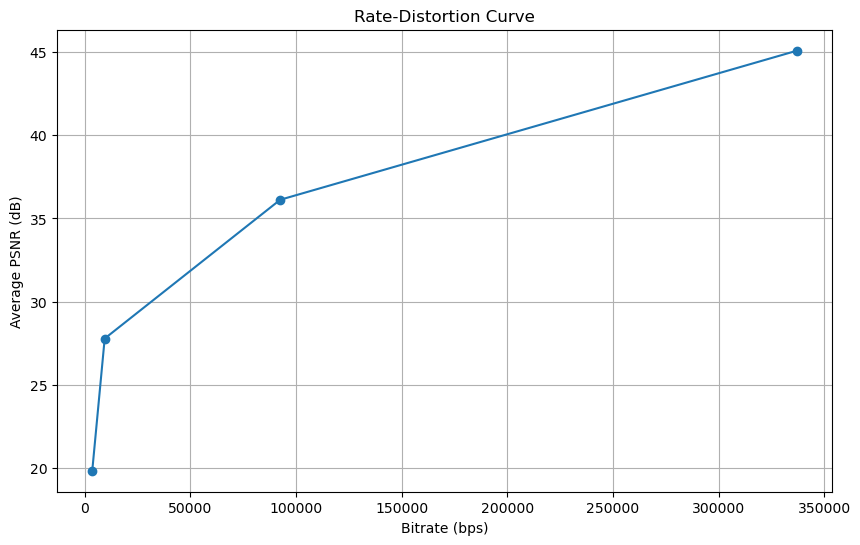

In [3]:
def test_encoder_performance(encoder_class, input_video_path, output_folder, frame_height, frame_width, num_frames_to_process, QP_values):
    rd_data = {}
    C = 20
    QP_values = [1, 4, 7, 10]

    # Calculating lambda values for each QP
    lambda_values = {QP: C * QP**2 for QP in QP_values}
    lambda_values
    
    start_time = time.time()
    for QP in QP_values:
        encoder = encoder_class(input_video_path, frame_height, frame_width, block_size=16, search_range=4,
                                I_period=8, QP=QP, output_folder=output_folder, nRefFrames=1,
                                VBSEnable=True, lambda_map=lambda_values, FMEenable = False, FastME = False)
#         encoder = encoder_class(input_video_path, frame_height, frame_width, block_size=16, search_range=4,
#                                 I_period=8, QP=QP, output_folder=output_folder, nRefFrames=1)
        encoder.encode(num_frames_to_process)
        # Calculate average bitrate
        total_bitcount = encoder.total_bitcount
        avg_bitrate = total_bitcount / num_frames_to_process  # bits per frame

        # Collect data for RD plot
        avg_psnr = encoder.avg_PSNR

        rd_data[QP] = (avg_bitrate, avg_psnr)
    end_time = time.time()
    print("lambda:", encoder.lambda_map)
    print("Time cost:", end_time - start_time)
    return rd_data
    

# Example usage
QP_values = [1, 4, 7, 10]
rd_data = test_encoder_performance(Encoder, input_filepath, output_folder, 288, 352, 10, QP_values)

# Output the data for analysis
print("RD Data (QP: (Average Bitrate, Average PSNR)):")
for QP, data in rd_data.items():
    print(f"QP={QP}: Bitrate={data[0]} bps, PSNR={data[1]} dB")

def plot_rd_curve(data, title="Rate-Distortion Curve"):
    plt.figure(figsize=(10, 6))

    # Prepare lists for bitrate and PSNR
    bitrates = []
    psnrs = []

    for QP, (bitrate, psnr) in sorted(data.items()):
        bitrates.append(bitrate)
        psnrs.append(psnr)

    plt.plot(bitrates, psnrs, marker='o', linestyle='-')  # Connect the points
    plt.title(title)
    plt.xlabel('Bitrate (bps)')
    plt.ylabel('Average PSNR (dB)')
    plt.grid(True)
    plt.show()

# Plot the RD curve
plot_rd_curve(rd_data)

In [4]:
frame_height = 288
frame_width = 352
# block_sizes = 2, 8, 64
block_size = 8
# search_ranges = 1, 4, 8
search_range = 2
I_period = 4
QP = 3
num_frames_to_process = 10

encoder = Encoder(
    input_filepath=input_filepath,
    frame_height=frame_height,
    frame_width=frame_width,
    block_size=block_size,
    search_range=search_range,
    I_period=I_period,
    QP=QP,
    output_folder=output_folder
)

start_time = time.time()

encoder.encode(num_frames_to_process)

print("--- %s seconds ---" % (time.time() - start_time))
print(encoder.frames_bitcount)
print(encoder.total_bitcount)
print(encoder.avg_PSNR)


--- 10.314357280731201 seconds ---
[188801, 144041, 145588, 138069, 189986, 141217, 123227, 150810, 195367, 137085]
1554191
38.98389654658284


## 6 Curves

Config - nRefFrames: 1, VBSEnable: False, FMEenable: False, FastME: False
Time cost: 27.759328603744507
Config - nRefFrames: 2, VBSEnable: False, FMEenable: False, FastME: False
Time cost: 39.13145875930786
Config - nRefFrames: 1, VBSEnable: True, FMEenable: False, FastME: False
Time cost: 359.8377375602722
Config - nRefFrames: 1, VBSEnable: False, FMEenable: True, FastME: False
Time cost: 68.74151515960693
Config - nRefFrames: 1, VBSEnable: False, FMEenable: False, FastME: True
Time cost: 14.265475511550903
Config - nRefFrames: 2, VBSEnable: True, FMEenable: True, FastME: True
Time cost: 122.83754658699036


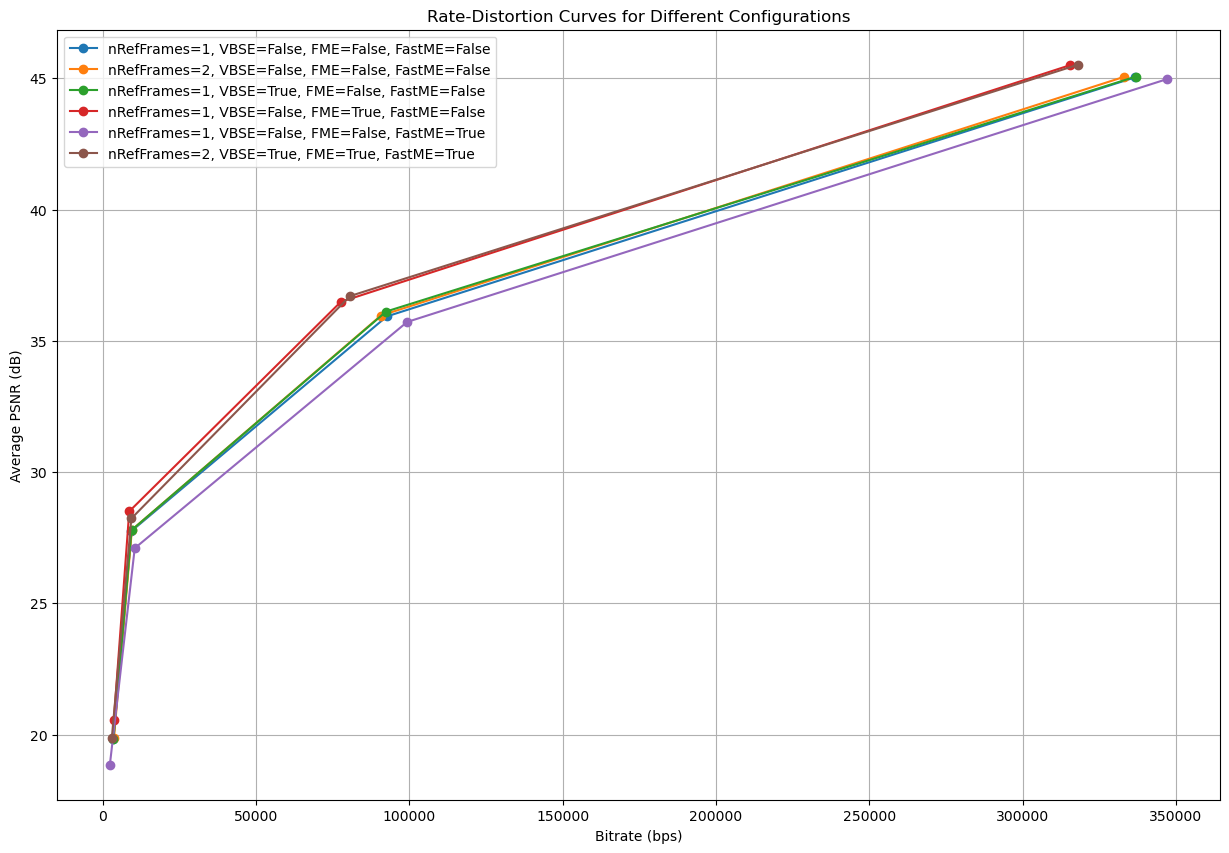

In [5]:
QP_values = [1, 4, 7, 10]
def test_encoder_performance(encoder_class, input_video_path, output_folder, frame_height, frame_width, num_frames_to_process, QP_values, nRefFrames, VBSEnable, FMEenable, FastME):
    rd_data = {}
    C = 20
    lambda_values = {QP: C * QP**2 for QP in QP_values}
    
    start_time = time.time()
    for QP in QP_values:
        encoder = encoder_class(input_video_path, frame_height, frame_width, block_size=16, search_range=4,
                                I_period=8, QP=QP, output_folder=output_folder, nRefFrames=nRefFrames,
                                VBSEnable=VBSEnable, lambda_map=lambda_values, FMEenable=FMEenable, FastME=FastME)
        encoder.encode(num_frames_to_process)
        avg_bitrate = encoder.total_bitcount / num_frames_to_process
        avg_psnr = encoder.avg_PSNR
        rd_data[QP] = (avg_bitrate, avg_psnr)
    end_time = time.time()
    print(f"Config - nRefFrames: {nRefFrames}, VBSEnable: {VBSEnable}, FMEenable: {FMEenable}, FastME: {FastME}")
    print("Time cost:", end_time - start_time)
    return rd_data

def plot_multiple_rd_curves(encoder_class, input_video_path, output_folder, frame_height, frame_width, num_frames_to_process, QP_values):
    plt.figure(figsize=(15, 10))
    configurations = [
        (1, False, False, False),
        (2, False, False, False),
        (1, True, False, False),
        (1, False, True, False),
        (1, False, False, True),
        (2, True, True, True)
    ]

    for nRefFrames, VBSEnable, FMEenable, FastME in configurations:
        rd_data = test_encoder_performance(encoder_class, input_video_path, output_folder, frame_height, frame_width, num_frames_to_process, QP_values, nRefFrames, VBSEnable, FMEenable, FastME)
        bitrates = [data[0] for data in rd_data.values()]
        psnrs = [data[1] for data in rd_data.values()]
        plt.plot(bitrates, psnrs, marker='o', linestyle='-', label=f'nRefFrames={nRefFrames}, VBSE={VBSEnable}, FME={FMEenable}, FastME={FastME}')

    plt.title("Rate-Distortion Curves for Different Configurations")
    plt.xlabel('Bitrate (bps)')
    plt.ylabel('Average PSNR (dB)')
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage
plot_multiple_rd_curves(Encoder, input_filepath, output_folder, 288, 352, 10, QP_values)

## The percentage of blocks chosen to split

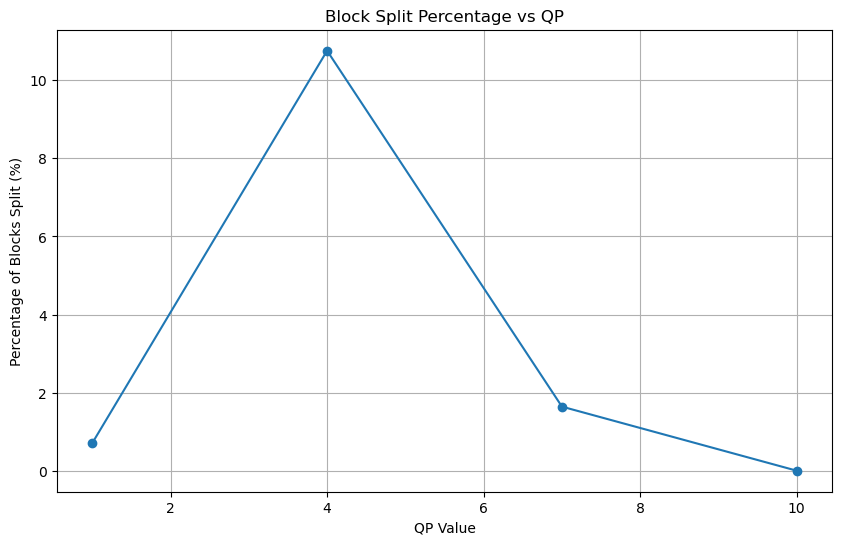

In [6]:
def split_percentage(encoder_class, input_video_path, output_folder, frame_height, frame_width, num_frames_to_process, QP_values):
    rd_data = {}
    split_data = {}
    C = 20
    lambda_values = {QP: C * QP**2 for QP in QP_values}
    
    for QP in QP_values:
        encoder = encoder_class(input_video_path, frame_height, frame_width, block_size=16, search_range=4,
                                I_period=8, QP=QP, output_folder=output_folder, nRefFrames=1,
                                VBSEnable=True, lambda_map=lambda_values, FMEenable=False, FastME=False)
        encoder.encode(num_frames_to_process)
        avg_bitrate = encoder.total_bitcount / num_frames_to_process
        avg_psnr = encoder.avg_PSNR
        rd_data[QP] = (avg_bitrate, avg_psnr)

        # Calculate percentage of blocks split
        split_percentage = encoder.splitPer  * 100
        split_data[QP] = split_percentage

    return rd_data, split_data

def plot_split_curve(split_data, title="Block Split Percentage vs QP"):
    plt.figure(figsize=(10, 6))
    QP_values = list(split_data.keys())
    split_percentages = list(split_data.values())

    plt.plot(QP_values, split_percentages, marker='o', linestyle='-')
    plt.title(title)
    plt.xlabel('QP Value')
    plt.ylabel('Percentage of Blocks Split (%)')
    plt.grid(True)
    plt.show()

# Example usage
QP_values = [1, 4, 7, 10]
rd_data, split_data = split_percentage(Encoder, input_filepath, output_folder, 288, 352, 10, QP_values)
plot_split_curve(split_data)

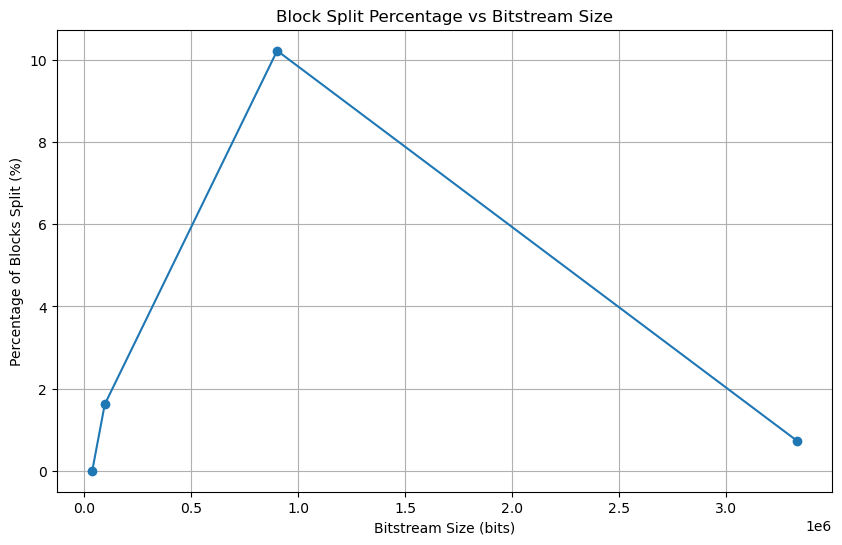

In [7]:
def test_encoder_performance(encoder_class, input_video_path, output_folder, frame_height, frame_width, num_frames_to_process, QP_values):
    split_data = {}
    C = 20
    lambda_values = {QP: C * QP**2 for QP in QP_values}
    
    for QP in QP_values:
        encoder = encoder_class(input_video_path, frame_height, frame_width, block_size=16, search_range=4,
                                I_period=8, QP=QP, output_folder=output_folder, nRefFrames=2,
                                VBSEnable=True, lambda_map=lambda_values, FMEenable=False, FastME=False)
        encoder.encode(num_frames_to_process)

        # Calculate percentage of blocks split
        split_percentage = encoder.splitPer * 100
        bitstream_size = encoder.total_bitcount  # Total bits used in bitstream
        split_data[bitstream_size] = split_percentage

    return split_data

def plot_bitstream_split_curve(split_data, title="Block Split Percentage vs Bitstream Size"):
    plt.figure(figsize=(10, 6))
    bitstream_sizes = sorted(split_data.keys())
    split_percentages = [split_data[size] for size in bitstream_sizes]

    plt.plot(bitstream_sizes, split_percentages, marker='o', linestyle='-')
    plt.title(title)
    plt.xlabel('Bitstream Size (bits)')
    plt.ylabel('Percentage of Blocks Split (%)')
    plt.grid(True)
    plt.show()

# Example usage
QP_values = [1, 4, 7, 10]
split_data = test_encoder_performance(Encoder, input_filepath, output_folder, 288, 352, 10, QP_values)
plot_bitstream_split_curve(split_data)

## Per-frame distortion/Bitstream vs Frame number Varing nRefs

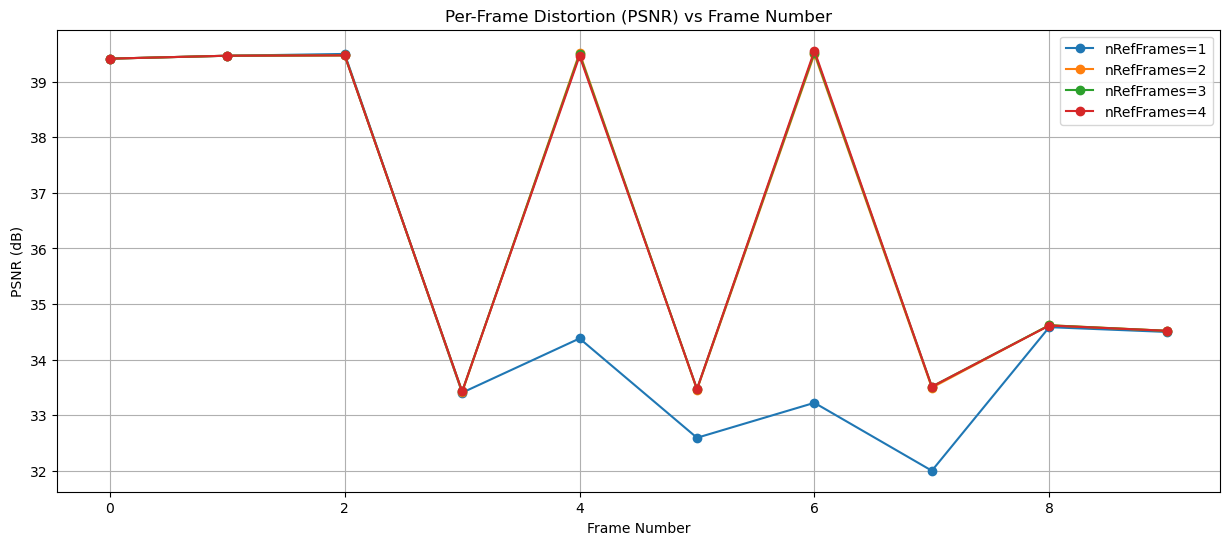

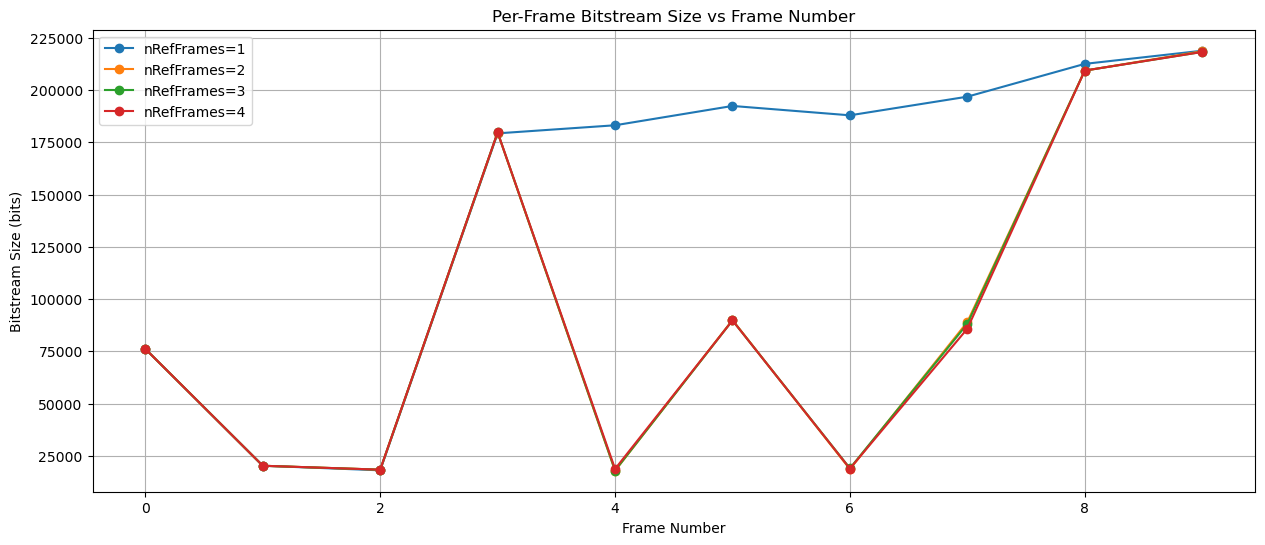

In [8]:
def test_encoder_performance(encoder_class, input_video_path, output_folder, frame_height, frame_width, num_frames_to_process, QP, nRefFrames):
    frame_data = {}
    for nRef in range(1, nRefFrames + 1):
        encoder = encoder_class(input_video_path, frame_height, frame_width, block_size=16, search_range=4,
                                I_period=8, QP=QP, output_folder=output_folder, nRefFrames=nRef,
                                VBSEnable=False, lambda_map={}, FMEenable=False, FastME=False)
        
        encoder.encode(num_frames_to_process)
        
        # Assuming encoder.distortion and encoder.frames_bitcount are lists of per-frame values
        distortions = encoder.distortion  # List of per-frame PSNR values
        bitstream_sizes = encoder.frames_bitcount  # List of per-frame bitstream sizes
        frame_data[nRef] = (bitstream_sizes, distortions)

    return frame_data

def plot_frame_data(frame_data, title, ylabel):
    plt.figure(figsize=(15, 6))
    for nRef, (bitstream_sizes, distortions) in frame_data.items():
        if ylabel == 'Bitstream Size (bits)':
            values = bitstream_sizes
        else:
            values = distortions

        # Check if the values list is not empty
        if values:
            frames = list(range(len(values)))
            plt.plot(frames, values, marker='o', linestyle='-', label=f'nRefFrames={nRef}')

    plt.title(title)
    plt.xlabel('Frame Number')
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.show()

# Example usage
QP = 4
num_frames_to_process = 10  # Example number of frames
frame_data = test_encoder_performance(Encoder, "synthetic.yuv", output_folder, 288, 352, num_frames_to_process, QP, 4)

# Plotting graphs
plot_frame_data(frame_data, "Per-Frame Distortion (PSNR) vs Frame Number", "PSNR (dB)")
plot_frame_data(frame_data, "Per-Frame Bitstream Size vs Frame Number", "Bitstream Size (bits)")

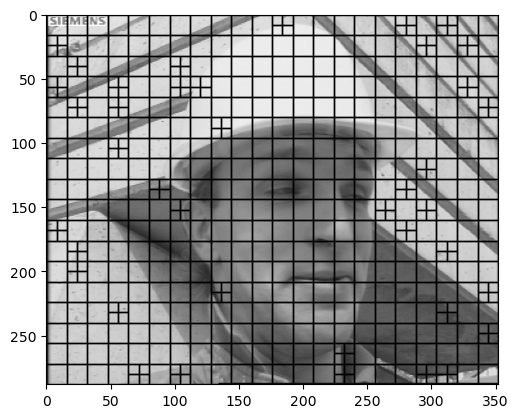

In [9]:
def draw_block_sizes_on_frame(frame, block_size_data, frame_index_to_visualize,frame_height, frame_width, max_block_size=16):
    # Create the figure and axis objects
    fig, ax = plt.subplots(1)
    ax.imshow(frame, cmap='gray', vmin=0, vmax=255)  # Assuming the frame is grayscale
    bks = block_size_data[frame_index_to_visualize]
    # Iterate over each macroblock position
    for y in range(0, frame_height, max_block_size):
        for x in range(0, frame_width, max_block_size):
            # If the macroblock was split into smaller blocks, draw those
            if (y, x) in bks:
                best_block_size = bks[(y, x)]
                if best_block_size != max_block_size:
                    # Draw each sub-block
                    for sub_y in range(y, y + max_block_size, best_block_size):
                        for sub_x in range(x, x + max_block_size, best_block_size):
                            sub_rect = patches.Rectangle((sub_x, sub_y), best_block_size, best_block_size,
                                                         linewidth=1, edgecolor='black', facecolor='none')
                            ax.add_patch(sub_rect)
            else:
                # Otherwise, draw the macroblock
                macro_rect = patches.Rectangle((x, y), max_block_size, max_block_size,
                                               linewidth=1, edgecolor='black', facecolor='none')
                ax.add_patch(macro_rect)

    # Set the axis limits and show the plot
    ax.set_xlim([0, frame_width])
    ax.set_ylim([frame_height, 0])  # Inverted y-axis for proper image orientation
    plt.show()

# Example usage:
C = 20
QP_values = [1, 4, 7, 10]
lambda_values = {QP: C * QP**2 for QP in QP_values}

encoder = Encoder(input_filepath, height, width, block_size=16, search_range=4,
                                I_period=8, QP=4, output_folder=output_folder, nRefFrames=1,
                                VBSEnable=True, lambda_map=lambda_values, FMEenable=False, FastME=False)
num_frames_to_process = 5
encoder.encode(num_frames_to_process)

frame_index_to_visualize = 3  # Replace with the frame index you want to visualize
original_frame = encoder.read_video_sequences(num_frames_to_process)[frame_index_to_visualize]  # The actual frame image data to be visualized
draw_block_sizes_on_frame(original_frame, encoder.block_size_data, frame_index_to_visualize, height, width)

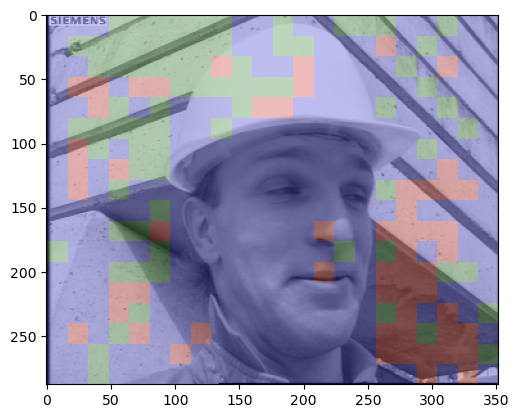

In [10]:
def draw_reference_frames_on_frame(frame, all_ref_frame_data, frame_index, frame_height, frame_width, block_size):
    # Check if the specified frame index is in the data
    if frame_index not in all_ref_frame_data:
        print(f"No reference frame data found for frame index {frame_index}.")
        return

    ref_frame_data = all_ref_frame_data[frame_index]

    # Define a color map for different reference frame indices
    color_map = {
        0: 'red',
        1: 'green',
        2: 'blue',
        3: 'yellow',
        # Add more colors if you have more reference frames
    }

    fig, ax = plt.subplots(1)
    ax.imshow(frame, cmap='gray', vmin=0, vmax=255)  # Assuming frame is grayscale

    # Draw rectangles for each block size in the current frame's data
    for (y, x), ref_frame_index in ref_frame_data.items():
        color = color_map.get(ref_frame_index, 'white')  # Default to white if index not in color_map
        # Create a rectangle patch
        rect = patches.Rectangle((x, y), block_size, block_size, linewidth=1, edgecolor='none', facecolor=color, alpha=0.2)
        ax.add_patch(rect)

    plt.show()

    # Example usage:
C = 20
QP_values = [1, 4, 7, 10]
lambda_values = {QP: C * QP**2 for QP in QP_values}

encoder = Encoder(input_filepath, height, width, block_size=16, search_range=4,
                                I_period=8, QP=4, output_folder=output_folder, nRefFrames=4,
                                VBSEnable=False, lambda_map=lambda_values, FMEenable=False, FastME=False)
num_frames_to_process = 5
encoder.encode(num_frames_to_process)

frame_index_to_visualize = 3  # Replace with the frame index you want to visualize
original_frame = encoder.read_video_sequences(num_frames_to_process)[frame_index_to_visualize]  # The actual frame image data to be visualized
draw_reference_frames_on_frame(original_frame, encoder.ref_frame_data, frame_index_to_visualize, height, width, encoder.block_size)

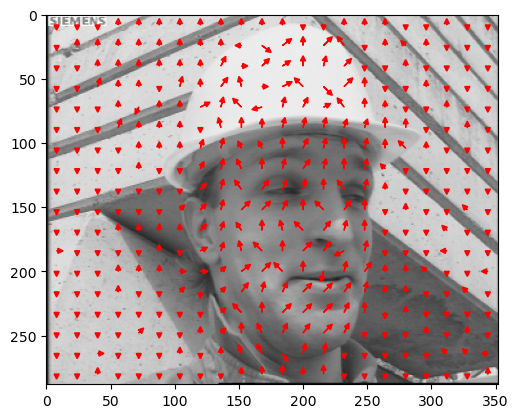

In [11]:
def draw_motion_vectors_on_frame(frame, all_motion_vector_data, frame_index, block_size, frame_height, frame_width):
    # Check if the specified frame index is in the data
    if frame_index not in all_motion_vector_data:
        print(f"No motion vector data found for frame index {frame_index}.")
        return
    
    # Get the motion vector data for the specified frame index
    motion_vector_data = all_motion_vector_data[frame_index]
    
    # Check if the frame has the correct shape (2D array)
    if frame.ndim != 2 or frame.shape[0] != frame_height or frame.shape[1] != frame_width:
        raise ValueError(f"Frame data has an invalid shape: {frame.shape}")

    # Create the figure and axis objects
    fig, ax = plt.subplots(1)
    ax.imshow(frame, cmap='gray', vmin=0, vmax=255)  # Assuming the frame is grayscale

    # Draw the motion vectors
    for (y, x), mv in motion_vector_data.items():
        # Ensure mv is iterable and has three items
        if not isinstance(mv, (list, tuple)) or len(mv) != 3:
            raise TypeError(f"Motion vector data for block ({y}, {x}) is invalid: {mv}")
        
        mv_x, mv_y, ref_idx = mv  # Unpack the motion vector and reference frame index
        # Optionally use ref_idx to change the color of the arrows or include it in the visualization
        ax.arrow(x + block_size/2, y + block_size/2, mv_x, mv_y, head_width=block_size/4, head_length=block_size/4, fc='red', ec='red')

    ax.set_xlim([0, frame_width])
    ax.set_ylim([frame_height, 0])  # Flip the y-axis so that the origin is at the top-left corner
    plt.show()

    # Example usage:
C = 20
QP_values = [1, 4, 7, 10]
lambda_values = {QP: C * QP**2 for QP in QP_values}

encoder = Encoder(input_filepath, height, width, block_size=16, search_range=4,
                                I_period=8, QP=4, output_folder=output_folder, nRefFrames=2,
                                VBSEnable=False, lambda_map=lambda_values, FMEenable=False, FastME=False)
num_frames_to_process = 5
encoder.encode(num_frames_to_process)

frame_index_to_visualize = 3  # Replace with the frame index you want to visualize
original_frame = encoder.read_video_sequences(num_frames_to_process)[frame_index_to_visualize]  # The actual frame image data to be visualized
draw_motion_vectors_on_frame(original_frame, encoder.all_motion_vector, frame_index_to_visualize, encoder.block_size, height, width)

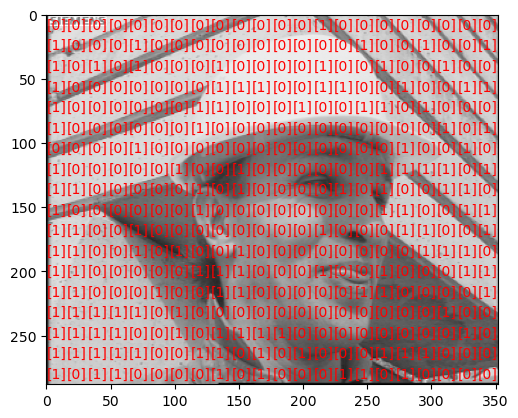

In [12]:
def draw_intra_modes_on_frame(frame, all_intra_mode_data, frame_index, block_size, frame_height, frame_width):
    # Check if the specified frame index is in the data
    if frame_index not in all_intra_mode_data:
        print(f"No intra mode data found for frame index {frame_index}.")
        return

    # Get the intra mode data for the specified frame index
    intra_mode_data = all_intra_mode_data[frame_index]

    # Check if the frame has the correct shape (2D array)
    if frame.ndim != 2 or frame.shape[0] != frame_height or frame.shape[1] != frame_width:
        raise ValueError(f"Frame data has an invalid shape: {frame.shape}")

    # Create the figure and axis objects
    fig, ax = plt.subplots(1)
    ax.imshow(frame, cmap='gray', vmin=0, vmax=255)  # Assuming the frame is grayscale

    # Annotate the modes
    for (y, x), mode in intra_mode_data.items():
        ax.text(x + block_size/2, y + block_size/2, str(mode), ha='center', va='center', color='red')

    ax.set_xlim([0, frame_width])
    ax.set_ylim([frame_height, 0])  # Flip the y-axis so that the origin is at the top-left corner
    plt.show()
    
    # Example usage:
C = 20
QP_values = [1, 4, 7, 10]
lambda_values = {QP: C * QP**2 for QP in QP_values}

encoder = Encoder(input_filepath, height, width, block_size=16, search_range=4,
                                I_period=8, QP=4, output_folder=output_folder, nRefFrames=2,
                                VBSEnable=False, lambda_map=lambda_values, FMEenable=False, FastME=False)
num_frames_to_process = 10
encoder.encode(num_frames_to_process)

frame_index_to_visualize = 8  # Replace with the frame index you want to visualize
original_frame = encoder.read_video_sequences(num_frames_to_process)[frame_index_to_visualize]  # The actual frame image data to be visualized
draw_intra_modes_on_frame(original_frame, encoder.all_intra_data, frame_index_to_visualize, encoder.block_size, height, width)